In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

from libs.visuals import gridline
from libs.visuals import gridcons
from libs.metrics import aggregators

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/temperature_analysis/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
PREFIX = 'temperature'

In [5]:
files = io.get_files(BENCHMARKS_PATH, f'{PREFIX}_per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(159350, 15)

In [6]:
# filtering out interventions (biased prompts and rag)
query_infra = "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"
df_per_attempt = df_per_attempt_all.query(query_infra).copy()
df_per_attempt.shape

(104205, 15)

In [7]:
df_models_metadata = io.pd.DataFrame(constants._llm_metadata.values())
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.model.str.split('/').str[-1].str.replace('-instruct', '').str.replace('-it', '')
df_models_metadata.loc[:, 'model_access'] = df_models_metadata.model.apply(lambda x: 'propietary' if 'gemini' in x else 'open')
df_models_metadata.loc[:, 'model_size'] = df_models_metadata['class'].apply(lambda x: x.split(' ')[0])
df_models_metadata.loc[:, 'model_class'] = df_models_metadata.reasoning.apply(lambda x: 'R' if x else 'NR')
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: f"{row.model_name}-grounded" if row.grounded == True else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: 'llama-4-mav' if row.model_name =='llama-4-maverick' else row.model_name, axis=1)
df_models_metadata.model_name = df_models_metadata.model_name.apply(lambda x: 'llama-3.3-8b' if x == 'llama-3.1-8b' else x)
df_models_metadata.shape


(24, 26)

## Model group and Temperature groups

In [8]:
df_summary_temperature_group = io.pd.DataFrame()
for group in constants.BENCHMARK_MODEL_GROUPS:
    groupby = [group, 'temperature', 'metric_name']
    per_group = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=0.05, metric_value_col='metric_value', metric_name_col='metric_name')
    per_group.rename(columns={group: 'model_kind'}, inplace=True)
    per_group.loc[:, 'model_group'] = group
    cols_order = ['model_group','model_kind', 'temperature', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
    per_group = per_group[cols_order]
    df_summary_temperature_group = io.pd.concat([df_summary_temperature_group, per_group], axis=0, ignore_index=True)

df_summary_temperature_group.shape

(1008, 12)

In [9]:
df_summary_temperature_group.head(5)

,model_group,model_kind,temperature,n,metric_name,mean,std,median,sum,ci,ci_low,ci_high
0,model_access,open,0.0,813,connectedness,0.125041,0.175409,0.061386,101.658316,0.012075,0.112966,0.137116
1,model_access,open,0.0,813,connectedness_density,0.123827,0.180633,0.077778,100.671486,0.012435,0.111392,0.136262
2,model_access,open,0.0,813,connectedness_ncomponents,0.842510,0.179148,0.888889,684.960924,0.012333,0.830178,0.854843
3,model_access,open,0.0,813,connectedness_norm_entropy,0.874959,0.175409,0.938614,711.341684,0.012075,0.862884,0.887034
4,model_access,open,0.0,289,consistency,0.444334,0.322604,0.394231,128.412429,0.037351,0.406983,0.481684


# Plots

In [10]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

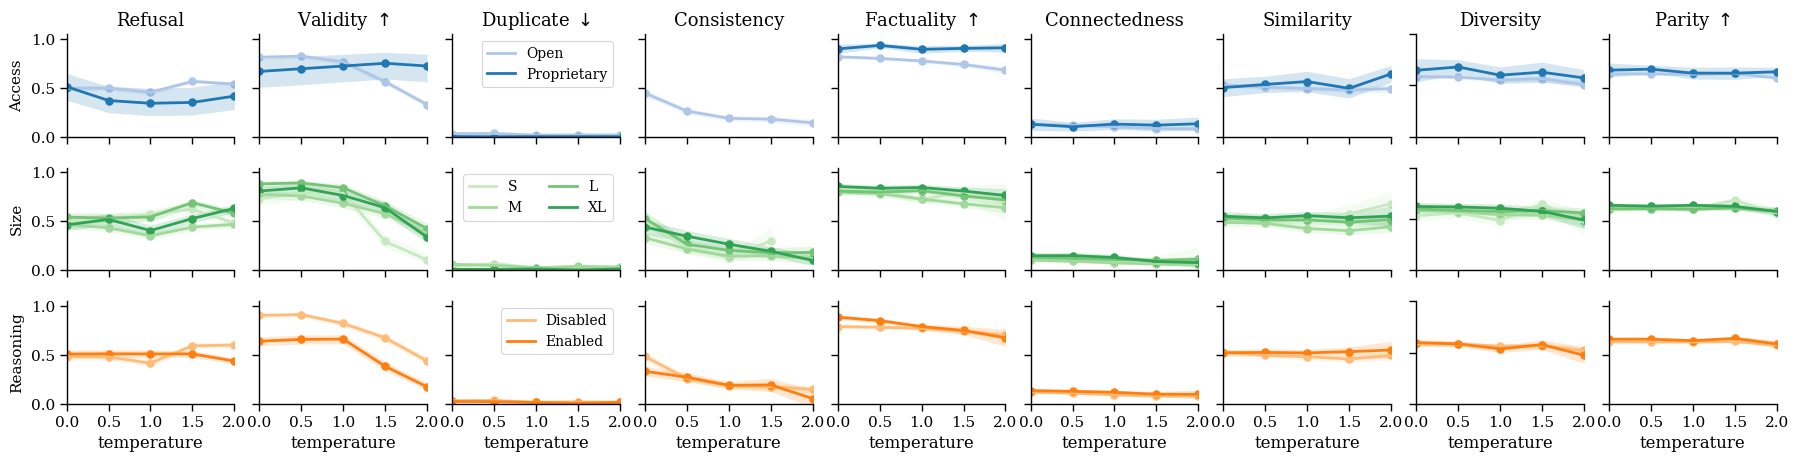

In [11]:
index = ['model_group','model_kind', 'temperature']
hue_colors = {sg:gridcons.GROUP_COLORS[group][i] for group, values in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP.items() for i, sg in enumerate(values)}
group_order = constants.BENCHMARK_MODEL_GROUPS

values = (
    df_summary_temperature_group.pivot(index=index, columns='metric_name', values='mean')
)

ci_low = (
    df_summary_temperature_group.pivot(index=index, columns='metric_name', values='ci_low')
)

ci_high = (
    df_summary_temperature_group.pivot(index=index, columns='metric_name', values='ci_high')
)


fig = gridline.plot_metric_grid_temperature_from_pivot(
    values,
    ci_low=ci_low,
    ci_high=ci_high,
    panels=gridcons.PANELS_METRICS,  # your PanelSpec list
    left_group_cols=[index[0]],
    series_col=index[1],
    row_label_maps={'model_group':constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP},
    x_col=index[2],
    x_order=[0.0, 0.5, 1.0, 1.5, 2.0],  # optional explicit x order
    series_colors=hue_colors,
    group_order=group_order,
    series_order=constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP,
    series_label_map = {k:v for k,v in constants.BENCHMARK_MODEL_GROUP_LABEL_MAP.items() if k not in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP['model_size']},
    layout=gridline.LayoutSpec(figsize=(18, 5.), wspace=0.15, separator_lw=0.5, label_ratio=0.1),
    style=gridline.StyleSpec(title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10, legend_fontsize=10, legend_frameon=True, row_label_x=-0.3, grid_x=False, grid_y=False, ylabel_pad=10),

    add_legend=True,
    legend_panel=[(0, 2),(1,2),(2,2)],
    legend_kwargs = [{}, {'ncols':2}, {}]
)

fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_model_group.pdf')
if fn is not None:
    fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

gridline.plt.show()
gridline.plt.close()